# Simulation of the Aleph TPC

In this example we demostrate how to connect the [PYTHIA]() MC generator to a
to a Geant4 application that implementes a very simplistic model of the ALEPH TPC.

The TPC detector is a simple cylinder filled with a mixture of Argon and Methane gas inside
an axial 1.5 testla magnetic field. The primary particles are generated by PYTHIA8 with the
the LEP collision settings.

## Loading the necessary Julia modules
- `Geant4` and `Geant4.SystemOfUnits` for the Geant4 simulation
- `Parameters` for the parameter handling in the detector definition
- `PYTHIA8` for the PYTHIA8 generator

In [1]:
using Geant4
using Geant4.SystemOfUnits
using Parameters
using PYTHIA8

# to force loading G4Vis extension we need to load the following modules
using CairoMakie, Rotations, IGLWrap_jll, LinearAlgebra
using PYTHIA8: px, py, pz
import DisplayAs: PNG

## Define the TPC Detector
The TPC detector is a simple cylinder filled with a mixture of Ar and CH4 gas

In [2]:
using Geant4.SystemOfUnits: m, cm, mole,cm3

The structure `AlephTPC` is defined with the default detector parameters

In [3]:
@with_kw mutable struct AlephTPC <: G4JLDetector
    totalL::Float64 = 4.4m      # total length of the TPC
    innerR::Float64 = 0.31m     # inner radius of the TPC
    outerR::Float64 = 1.8m      # outer radius of the TPC
    checkOverlaps::Bool = false # do check overlaps when creating the geometry
end

Main.var"##230".AlephTPC

The function `construct` is defined to create the geometry of the TPC detector. It receives
an instance of the `AlephTPC` structure and returns a pointer to the physical volume of the world.

In [4]:
function construct(det::AlephTPC)::CxxPtr{G4VPhysicalVolume}
    (; totalL, innerR, outerR, checkOverlaps) = det

    ##---Materials----------------------------------------------------------------------------------
    nist = G4NistManager!Instance()
    m_Ar     = FindOrBuildMaterial(nist, "G4_Ar")
    m_CH₄    = FindOrBuildMaterial(nist, "G4_METHANE")
    ArCH₄  = G4Material("ArCH₄", 3.491*mg/cm3, 2)
    AddMaterial( ArCH₄, m_Ar, 0.91 )
    AddMaterial( ArCH₄, m_CH₄,0.09 )
    m_ArCH₄  = FindOrBuildMaterial(nist, "ArCH₄")
    m_air    = FindOrBuildMaterial(nist, "G4_AIR")
    m_Al     = FindOrBuildMaterial(nist, "G4_Al")

    ##---Volumes------------------------------------------------------------------------------------
    worldZHalfLength = 1.1 * totalL/2
    worldS  = G4Box("world", worldZHalfLength, worldZHalfLength, worldZHalfLength)
    worldLV = G4LogicalVolume(worldS, m_air, "World")
    worldPV = G4PVPlacement(nothing, G4ThreeVector(), worldLV, "World", nothing, false, 0, checkOverlaps)

    fcOuterS  = G4Tubs("fcOuter", outerR, outerR + 1.8cm, totalL/2, 0, 2π)
    fcOuterLV = G4LogicalVolume(fcOuterS, m_Al, "fcOuter")
    fcInnerS  = G4Tubs("fcInner", innerR - 0.8cm, innerR, totalL/2, 0, 2π)
    fcInnerLV = G4LogicalVolume(fcInnerS, m_Al, "fcInner")

    chamberS  = G4Tubs("chamber", innerR, outerR, totalL/2, 0, 2π)
    chamberLV = G4LogicalVolume(chamberS, m_ArCH₄, "chamber")
    G4PVPlacement(nothing, G4ThreeVector(), fcOuterLV, "fcOuter", worldLV, false, 0, checkOverlaps)
    G4PVPlacement(nothing, G4ThreeVector(), fcInnerLV, "fcInner", worldLV, false, 0, checkOverlaps)
    G4PVPlacement(nothing, G4ThreeVector(), chamberLV, "chamber", worldLV, false, 0, checkOverlaps)
    ##SetUserLimits(chamberLV, G4UserLimits(5mm))

    ##---Visualization attributes------------------------------------------------------------------
    boxVisAtt = G4VisAttributes(G4Colour(1.0, 1.0, 1.0, 0.0))
    chamberVisAtt = G4VisAttributes(G4Colour(0.0, 1.0, 1.0, 0.2))
    fcVisAtt = G4VisAttributes(G4Colour(0.0, 1.0, 0.0, 0.1))
    SetVisAttributes(worldLV, boxVisAtt)
    SetVisAttributes(chamberLV, chamberVisAtt)
    SetVisAttributes(fcInnerLV, fcVisAtt)
    SetVisAttributes(fcOuterLV, fcVisAtt)

    ##---Always return the physical world-------------------------------------------------------------
    return worldPV
end
Geant4.getConstructor(::AlephTPC)::Function = construct

Finally, the detector is created with the default parameters

In [5]:
tpc = AlephTPC()          # create the detector

Main.var"##230".AlephTPC
  totalL: Float64 4400.0
  innerR: Float64 310.0
  outerR: Float64 1800.0
  checkOverlaps: Bool false


## Magnetic Field initialization

In [6]:
bfield = G4JLUniformMagField(G4ThreeVector(0,0, 1.5tesla))

Geant4.G4JLUniformMagField("UnifiormB", Geant4.G4JLUniformMagFieldData(G4ThreeVector(0.0,0.0,0.0015)), Geant4.var"#getfield!#33"(), Geant4.G4JLMagField[])

## Primary Particle Generator

In [7]:
@with_kw mutable struct PythiaGenerator <: G4JLGeneratorData
    eCM::Float64 = 91.2*GeV
    pythia = nothing
end

function LEPCollision()
    data = PythiaGenerator()
    function LEPinit(data::PythiaGenerator, app::G4JLApplication)
        data.pythia = PYTHIA8.Pythia("", false)
        data.pythia << "Beams:idA = -11" # positron
        data.pythia << "Beams:idB = 11"  # electron
        data.pythia << "Beams:eCM = $(data.eCM/GeV)" # CM energy
        data.pythia << "PDF:lepton = off" # no lepton PDFs
        # Process: hadronic decays of Z0. Initialize. Histogram.
        data.pythia << "WeakSingleBoson:ffbar2gmZ = on"
        data.pythia << "23:onMode = off"
        data.pythia << "23:onIfAny = 1 2 3 4 5"
        # If Pythia fails to initialize, exit with error.
        data.pythia |> init || error("Pythia initialization failed")
    end
    function LEPgenerate(g4evt::G4Event, data::PythiaGenerator)::Nothing
        # Generate event. Skip if error. List first one.
        data.pythia |> next || return
        evt = data.pythia |> event
        # Define primary vertex
        vertex = G4PrimaryVertex(G4ThreeVector(0,0,0), 0)
        # Loop over the particles in the Pythia event
        for p in evt
            if isFinal(p)
                primary = G4PrimaryParticle(p |> id, px(p)*GeV, py(p)*GeV, pz(p)*GeV)
                SetPrimary(vertex, move!(primary))    ## note that we give up ownership of the objects just created
            end
        end
        AddPrimaryVertex(g4evt, move!(vertex))  ## note that we give up ownership of the objects just created
    end
    G4JLPrimaryGenerator("LEPCollision", data; init_method=LEPinit, generate_method=LEPgenerate)
end

LEPCollision (generic function with 1 method)

## Event Display
Overwriting the default `drawEvent` function defined in the G4Vis extension

In [8]:
const G4Vis = Base.get_extension(Geant4, :G4Vis)
function G4Vis.drawEvent(evtdisp::G4Vis.G4JLEventDisplay)
    println("Drawing event", typeof(evtdisp))
    s = evtdisp.lscene.scene
    settings = evtdisp.settings
    trajectories = G4EventManager!GetEventManager() |> GetConstCurrentEvent |> GetTrajectoryContainer
    if trajectories != C_NULL
        points = Point3{Float64}[]
        for t in trajectories
            t |> GetCharge == 0 && continue # skip neutral particles
            npoints = GetPointEntries(t)
            npoints < 3 && continue         # skip particles with less than 3 points
            for i in 1:npoints
                pos = GetPoint(t, i-1) |> GetPosition
                r = sqrt(pos[0]^2 + pos[1]^2)
                z = pos[2]
                (r > 1.8m || abs(z) > 2.4m) && break  # kill particle outside the TPC
                if r > 0.38m                # skip points inside the beam pipe
                    push!(points, convert(Point3{Float64}, pos))
                else
                    push!(points, Point3{Float64}(NaN, NaN, NaN))
                end
            end
            push!(points, Point3{Float64}(NaN, NaN, NaN))
        end
        lines!(s, points, color=settings.trajectories.color, transparency=false, overdraw=false)
    end
    ##wait_for_key("Press any key to continue with next event")
end
evtdisplay = G4JLEventDisplay(joinpath(@__DIR__, "VisSettings.jl"))

G4Vis.G4JLEventDisplay((display = (backgroundcolor = :black, resolution = (1280, 720), show_axis = false, camera_rotation = (0, 0, -1.5707963267948966), camera_zoom = 0.1), trajectories = (color = :yellow,), detector = (show_detector = true,)), G4Vis.stateChange, G4Vis.initDisplay, #undef, #undef)

## Create the Application

In [9]:
app = G4JLApplication(detector     = tpc,                       # detector defined above
                      generator    = LEPCollision(),            # primary generator to instantiate
                      field        = bfield,                    # magnetic field
                      physics_type = FTFP_BERT,                 # what physics list to instantiate
                      evtdisplay   = evtdisplay                 # event display
                     );

configure(app)
initialize(app)


**************************************************************
 Geant4 version Name: geant4-11-02-patch-01 [MT]   (16-February-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************


 *-------  PYTHIA Process Initialization  --------------------------*
 |                                                                  |
 | We collide e+ with e- at a CM energy of 9.120e+01 GeV            |
 |                                                                  |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |              

## Run the Application


 --------  PYTHIA Info Listing  ---------------------------------------- 
 
 Beam A: id =    -11, pz =  4.560e+01, e =  4.560e+01, m =  5.110e-04.
 Beam B: id =     11, pz = -4.560e+01, e =  4.560e+01, m =  5.110e-04.

 In 1: id =  -11, x =  1.000e+00, pdf =  1.000e+00 at Q2 =  8.317e+03.
 In 2: id =   11, x =  1.000e+00, pdf =  1.000e+00 at same Q2.

 Subprocess f fbar -> gamma*/Z0 with code 221 is 2 -> 1.
 It has sHat =  8.317e+03.
     alphaEM =  7.818e-03,  alphaS =  1.300e-01    at Q2 =  8.317e+03.

 Impact parameter b =  0.000e+00 gives enhancement factor =  1.000e+00.
 Max pT scale for MPI =  9.120e+01, ISR =  9.120e+01, FSR =  9.120e+01.
 Number of MPI =     1, ISR =     0, FSRproc =     0, FSRreson =     5.

 --------  End PYTHIA Info Listing  ------------------------------------

 --------  PYTHIA Event Listing  (hard process)  -----------------------------------------------------------------------------------
 
    no         id  name            status     mothers   daughte

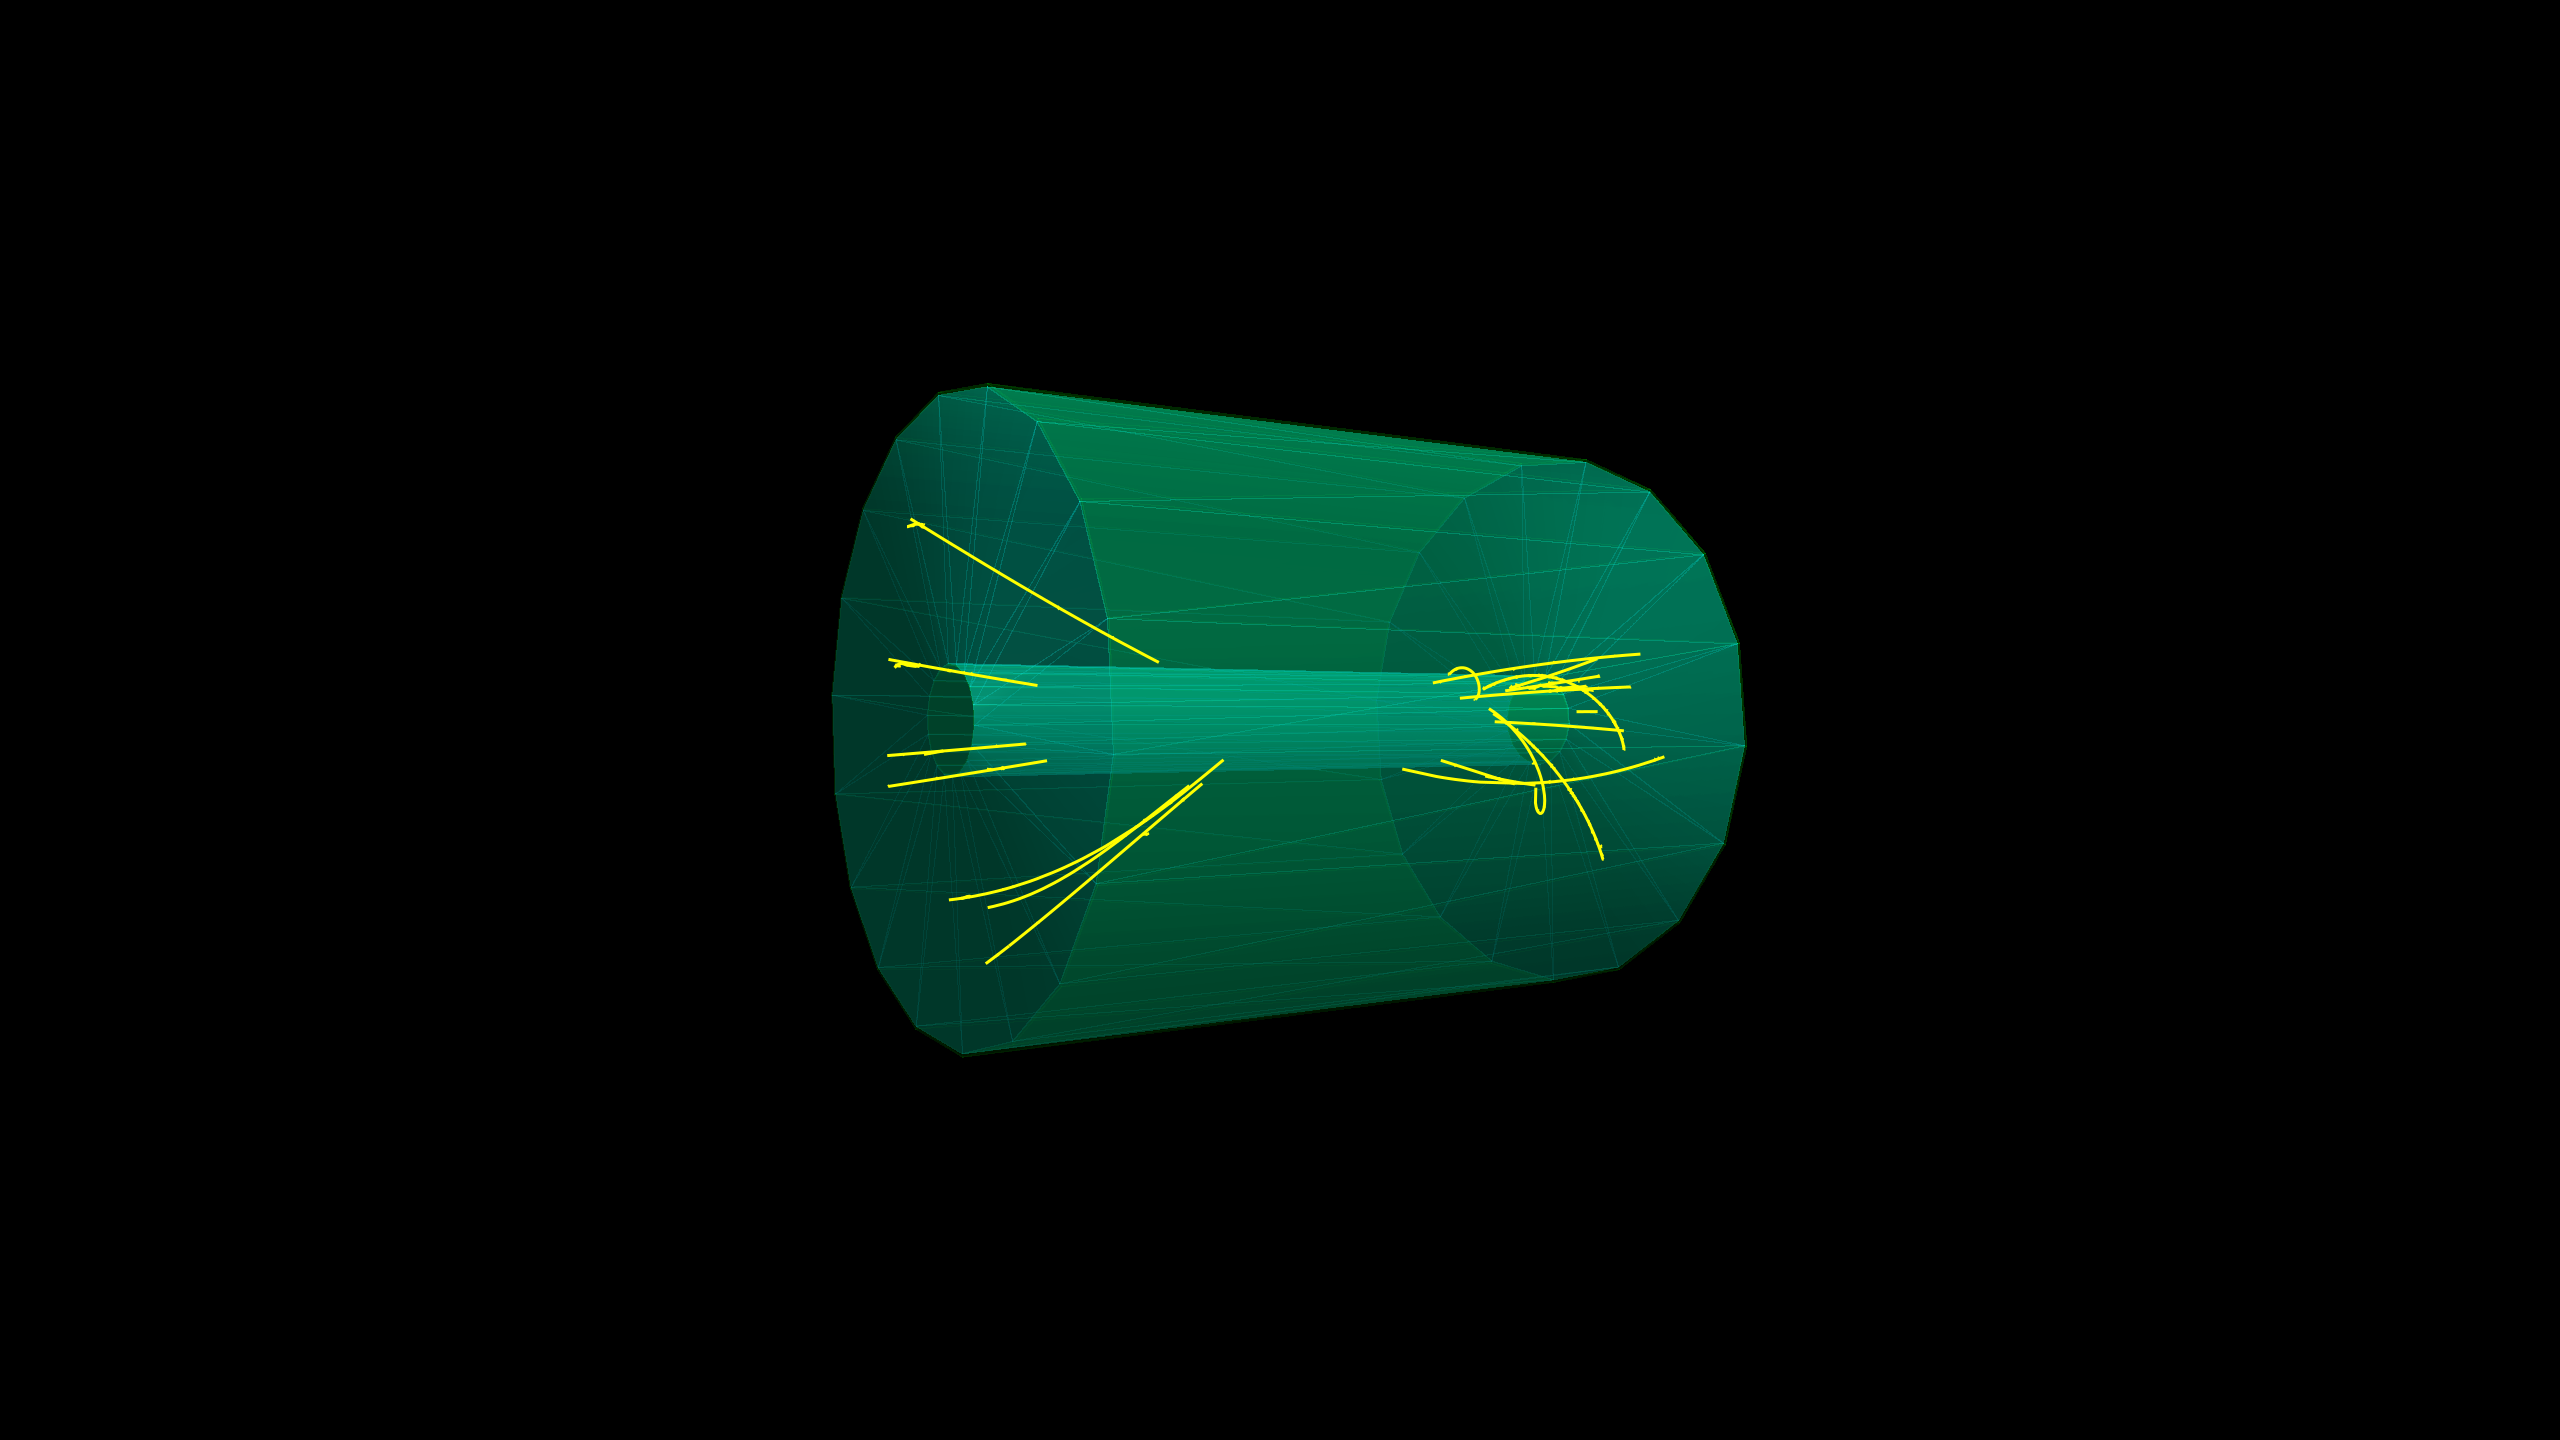

In [10]:
beamOn(app, 1)
PNG(evtdisplay.figure)

Another event

Drawing eventG4Vis.G4JLEventDisplay


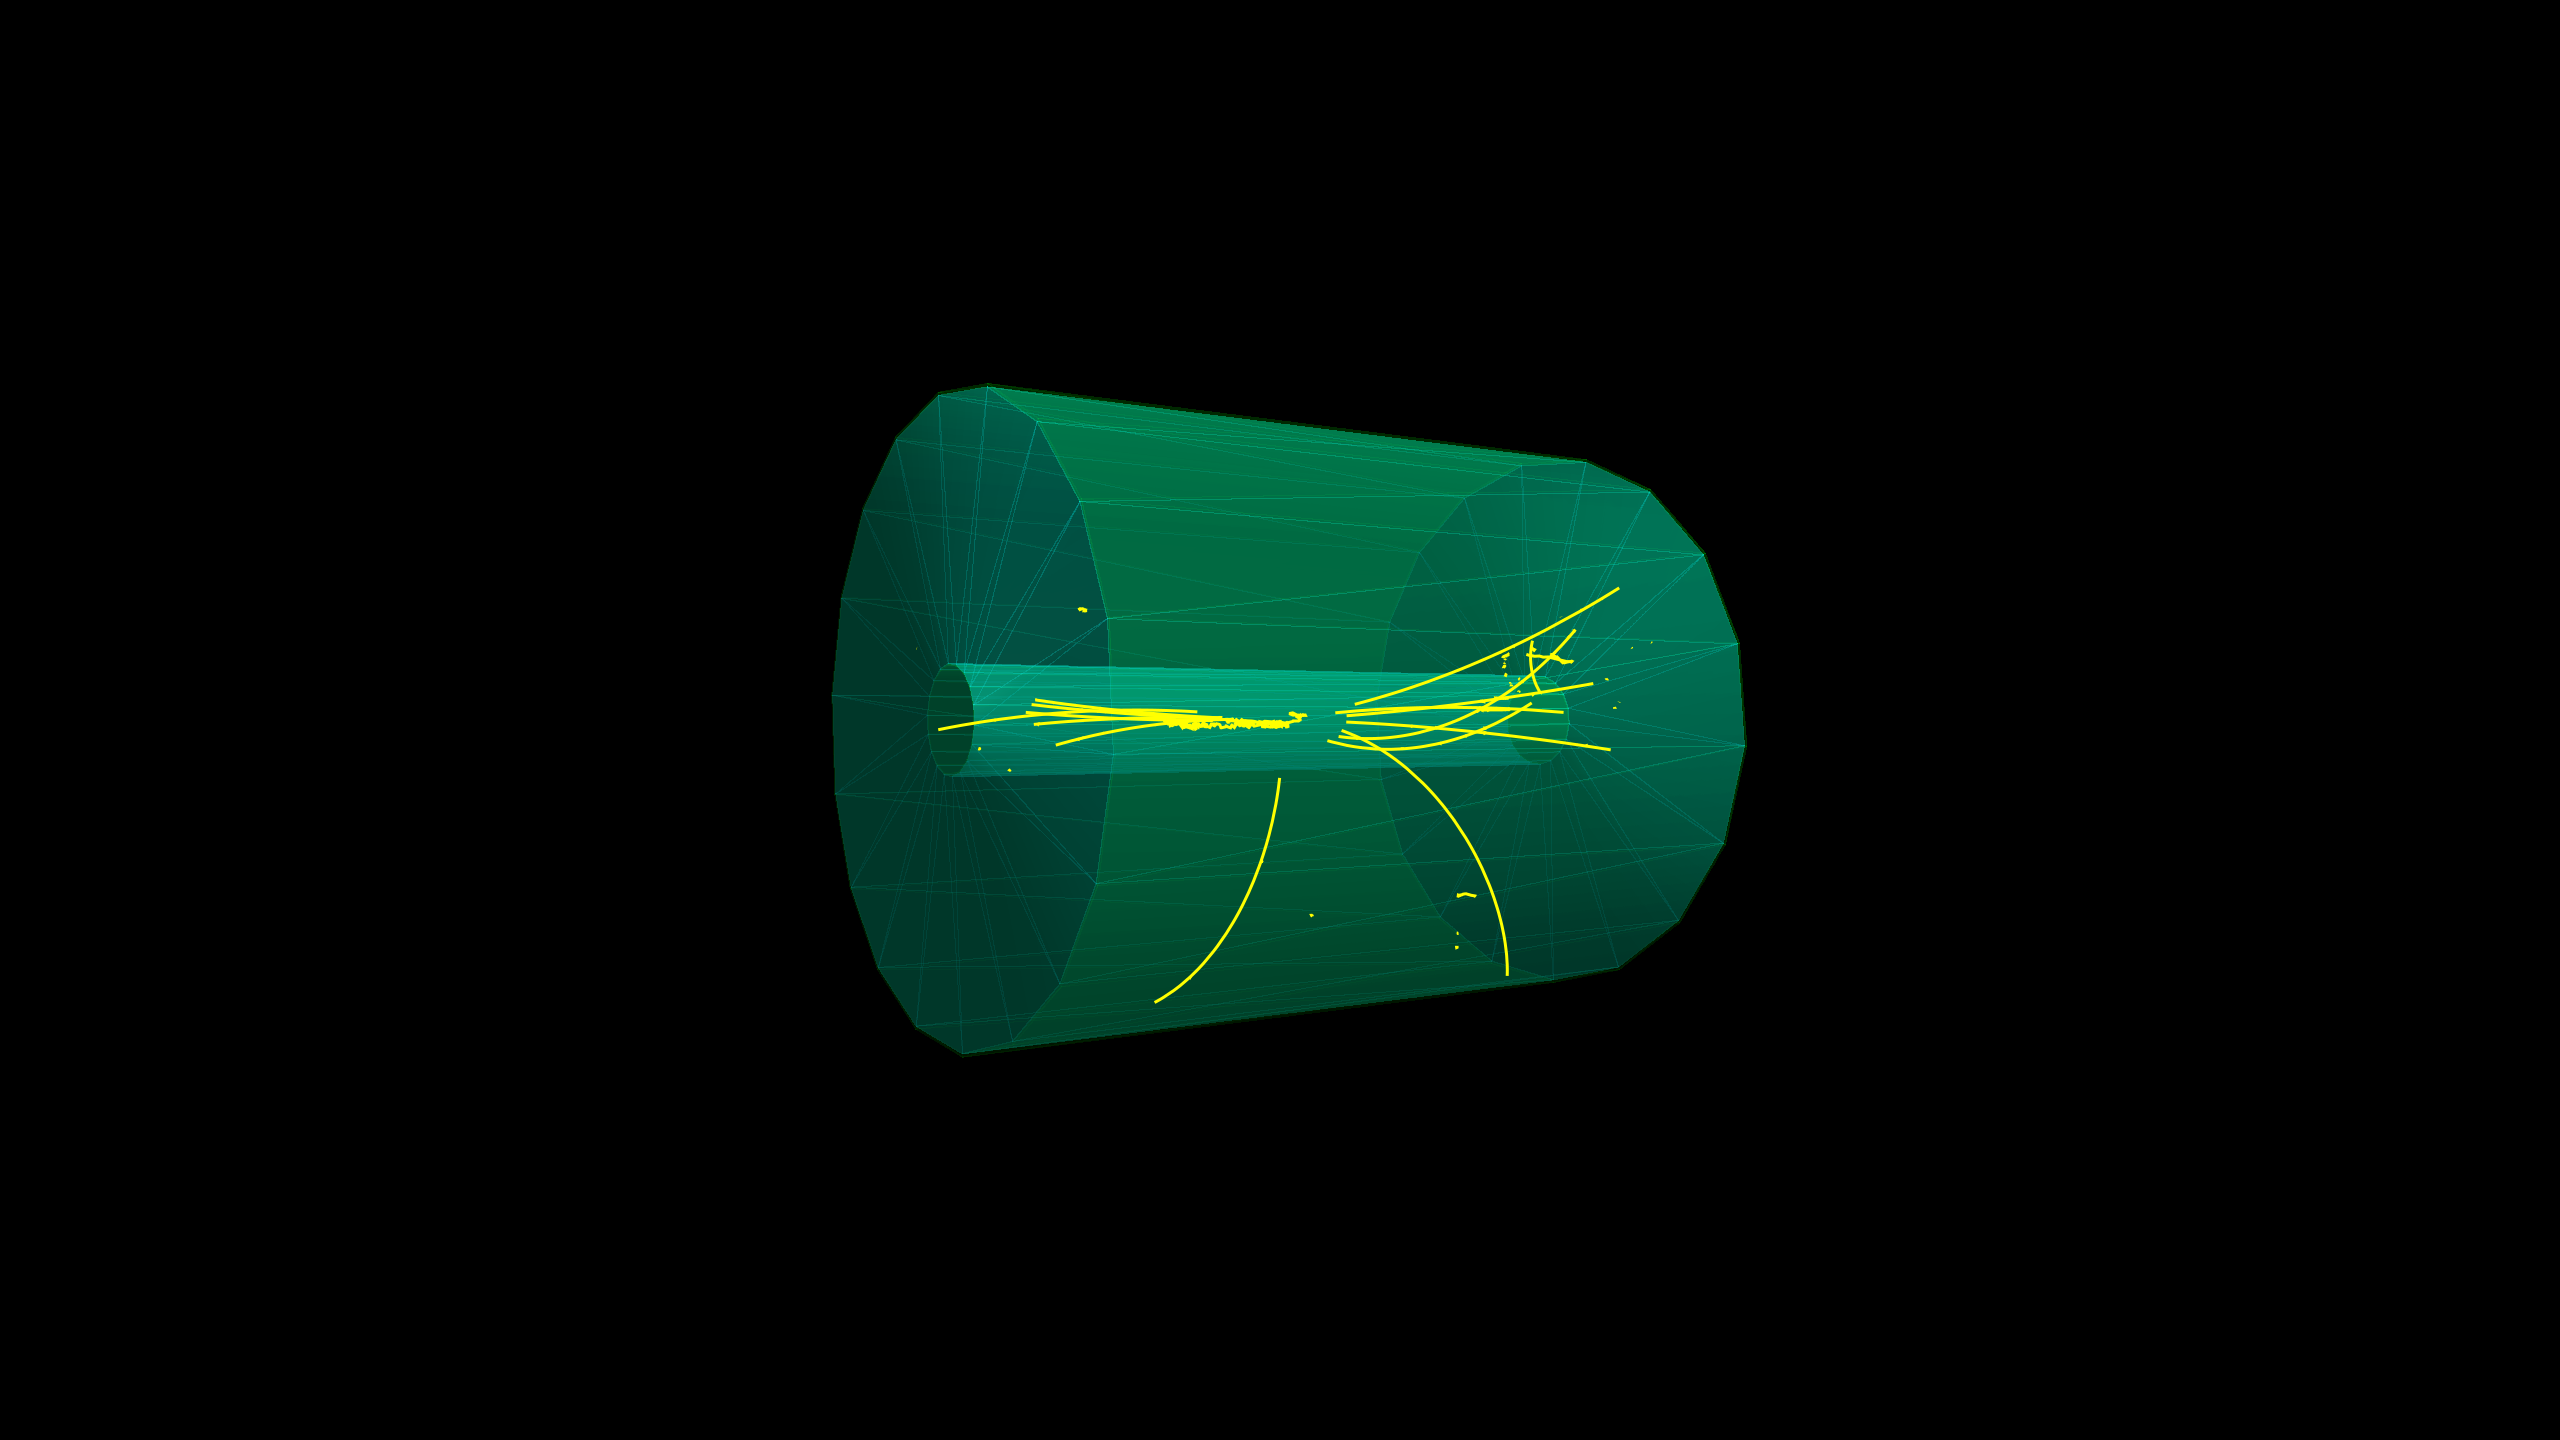

In [11]:
beamOn(app, 1)
PNG(evtdisplay.figure)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*